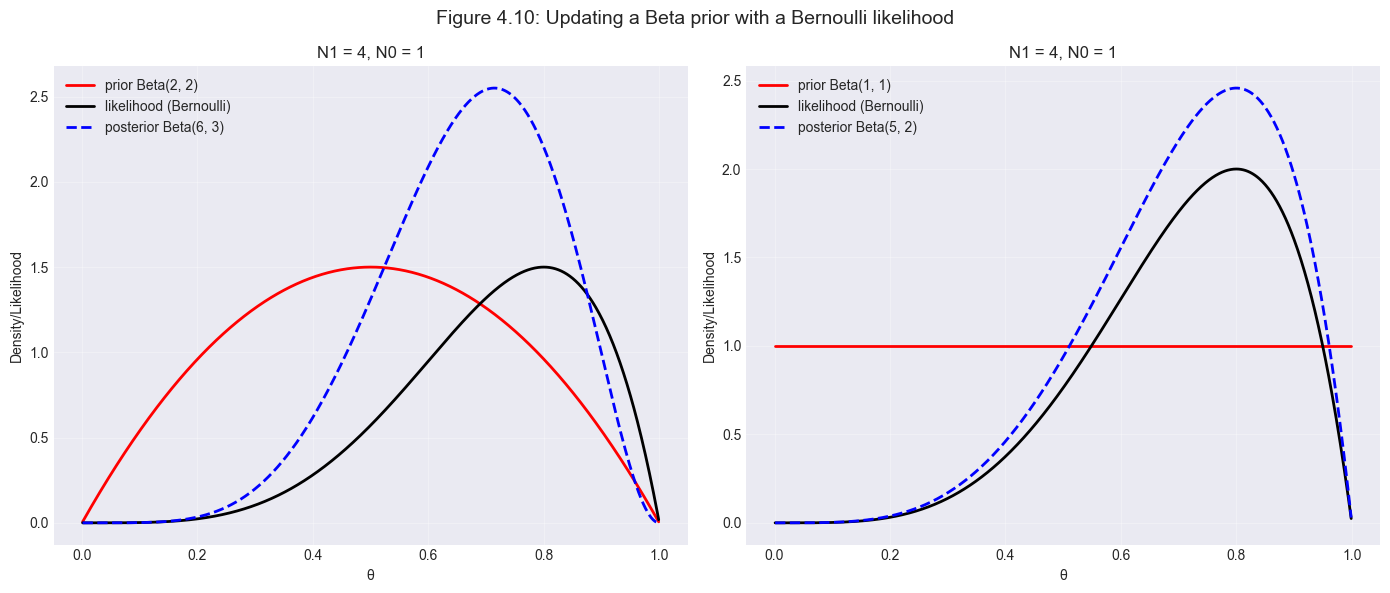

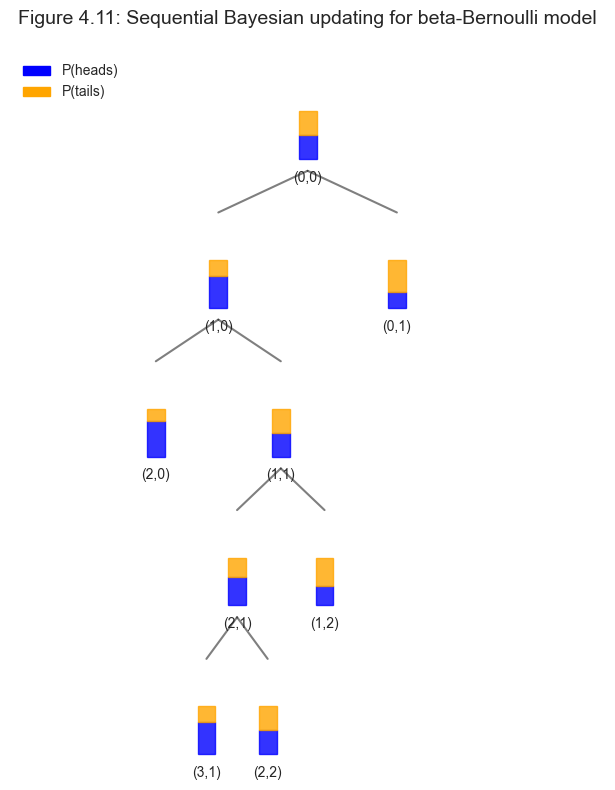

Laplace's Rule of Succession Example:
Observed: 3 heads, 0 tails
Using uniform prior Beta(1,1):
  Posterior: Beta(4, 1)
  P(next flip is heads) = 4/5 = 0.800

Using Beta(2,2) prior (add-one smoothing):
  MAP estimate = (3 + 1)/(3 + 0 + 2) = 0.800


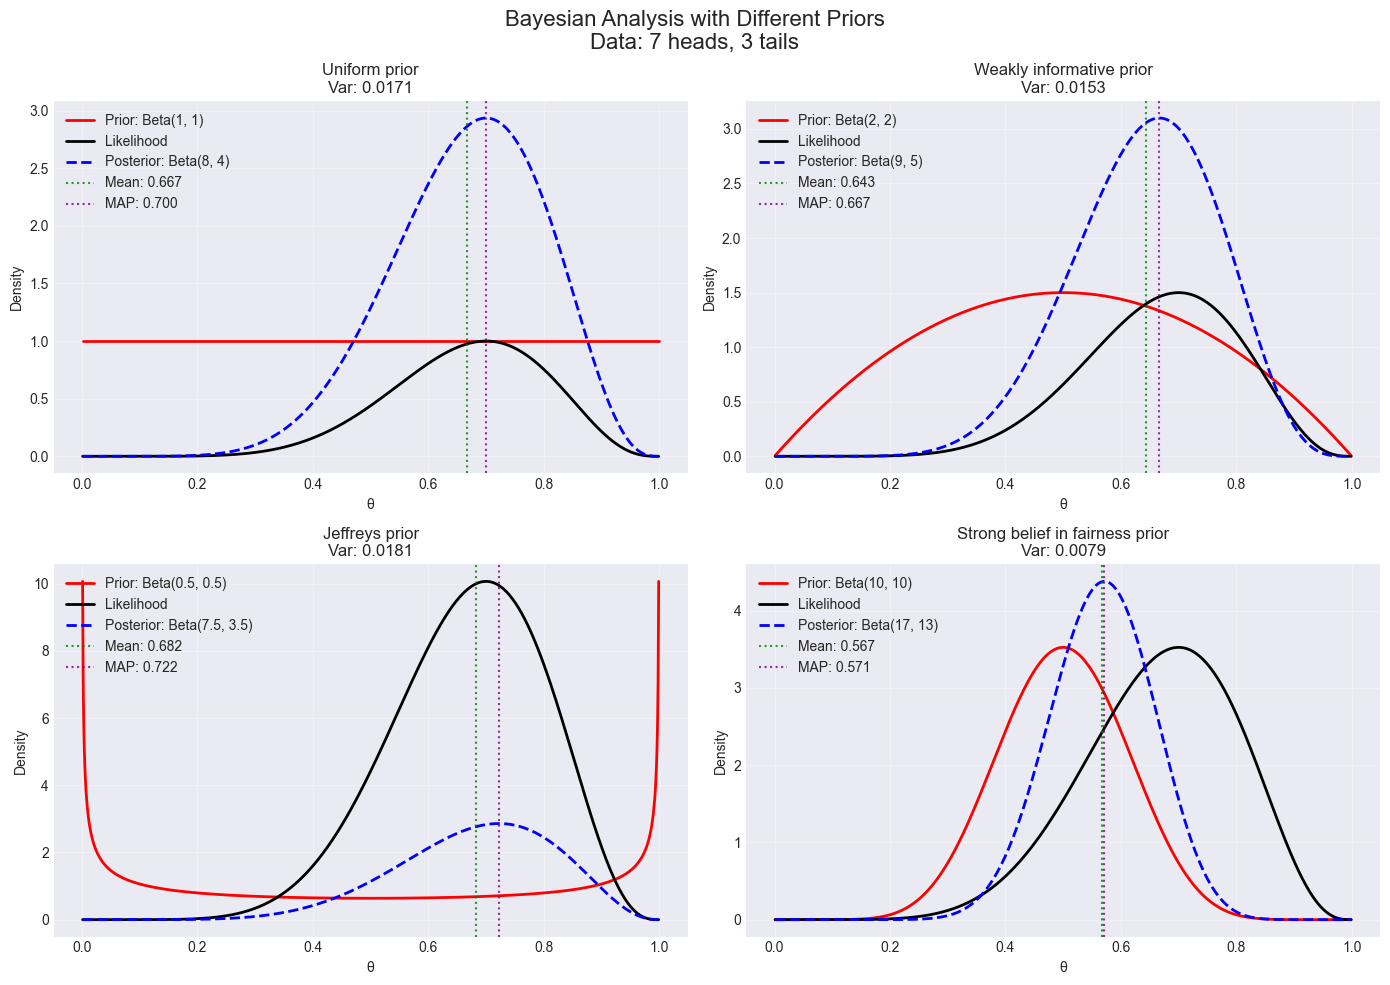



Posterior Predictive Example:
Posterior: Beta(8, 4)
P(next flip is heads) = 0.667


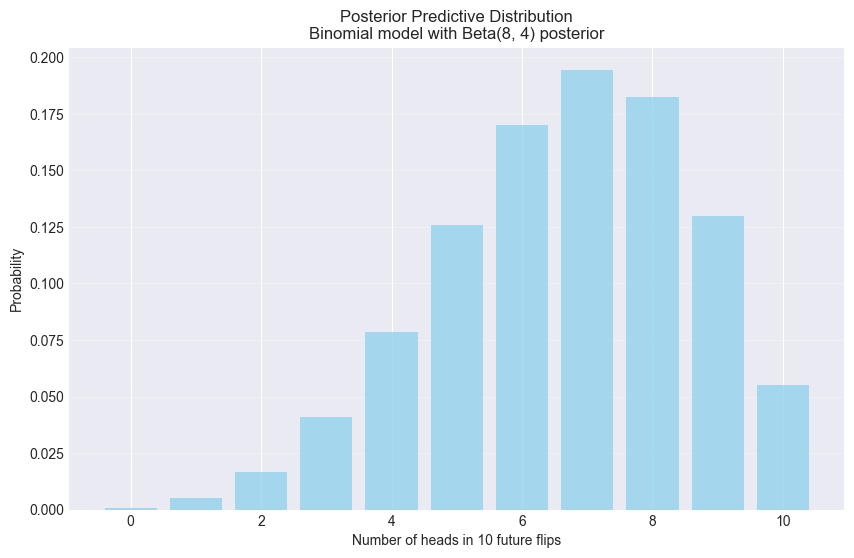

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom, betabinom
from scipy.special import gamma as gamma_func
import matplotlib.patches as mpatches

# Set style for prettier plots
plt.style.use('seaborn-v0_8-darkgrid')

# Bernoulli likelihood function
def bernoulli_likelihood(theta, N1, N0):
    """Bernoulli likelihood: p(D|θ) = θ^N1 * (1-θ)^N0"""
    return theta**N1 * (1-theta)**N0

# Binomial likelihood function
def binomial_likelihood(theta, n, y):
    """Binomial likelihood: p(D|θ) = C(n,y) * θ^y * (1-θ)^(n-y)"""
    # We ignore the binomial coefficient as it's independent of theta
    return theta**y * (1-theta)**(n-y)

# Beta posterior parameters
def beta_posterior_params(alpha, beta_param, N1, N0):
    """Calculate posterior parameters for Beta distribution"""
    alpha_post = alpha + N1
    beta_post = beta_param + N0
    return alpha_post, beta_post

# Figure 4.10: Updating Beta prior with Bernoulli likelihood
def plot_figure_4_10():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    theta = np.linspace(0.001, 0.999, 1000)
    
    # (a) Beta(2,2) prior with N1=4, N0=1
    alpha_prior, beta_prior = 2, 2
    N1, N0 = 4, 1
    
    # Prior
    prior_pdf = beta.pdf(theta, alpha_prior, beta_prior)
    ax1.plot(theta, prior_pdf, 'r-', linewidth=2, label=f'prior Beta({alpha_prior}, {beta_prior})')
    
    # Likelihood (normalized for visualization)
    likelihood = bernoulli_likelihood(theta, N1, N0)
    likelihood_norm = likelihood / np.max(likelihood) * np.max(prior_pdf)
    ax1.plot(theta, likelihood_norm, 'k-', linewidth=2, label='likelihood (Bernoulli)')
    
    # Posterior
    alpha_post, beta_post = beta_posterior_params(alpha_prior, beta_prior, N1, N0)
    posterior_pdf = beta.pdf(theta, alpha_post, beta_post)
    ax1.plot(theta, posterior_pdf, 'b--', linewidth=2, label=f'posterior Beta({alpha_post}, {beta_post})')
    
    ax1.set_xlabel('θ')
    ax1.set_ylabel('Density/Likelihood')
    ax1.set_title(f'N1 = {N1}, N0 = {N0}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # (b) Uniform Beta(1,1) prior with N1=4, N0=1
    alpha_prior, beta_prior = 1, 1
    
    # Prior
    prior_pdf = beta.pdf(theta, alpha_prior, beta_prior)
    ax2.plot(theta, prior_pdf, 'r-', linewidth=2, label='prior Beta(1, 1)')
    
    # Likelihood
    likelihood = bernoulli_likelihood(theta, N1, N0)
    likelihood_norm = likelihood / np.max(likelihood) * 2  # Scale for visualization
    ax2.plot(theta, likelihood_norm, 'k-', linewidth=2, label='likelihood (Bernoulli)')
    
    # Posterior
    alpha_post, beta_post = beta_posterior_params(alpha_prior, beta_prior, N1, N0)
    posterior_pdf = beta.pdf(theta, alpha_post, beta_post)
    ax2.plot(theta, posterior_pdf, 'b--', linewidth=2, label='posterior Beta(5, 2)')
    
    ax2.set_xlabel('θ')
    ax2.set_ylabel('Density/Likelihood')
    ax2.set_title(f'N1 = {N1}, N0 = {N0}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Figure 4.10: Updating a Beta prior with a Bernoulli likelihood', fontsize=14)
    plt.tight_layout()
    plt.show()

# Figure 4.11: Sequential Bayesian updating
def plot_figure_4_11():
    # Sequential coin flips: [H, T, H, H]
    observations = [1, 0, 1, 1]
    
    # Start with uniform prior Beta(1,1)
    alpha_prior, beta_prior = 1, 1
    
    # Create grid for visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Tree structure positions
    levels = len(observations) + 1
    y_positions = np.linspace(1, 0, levels)
    
    # Keep track of all paths and their parameters
    all_paths = []
    
    def draw_node(x, y, alpha, beta_param, N1, N0, path_prob=1.0):
        """Draw a node and its distribution"""
        # Calculate probability of heads
        p_heads = alpha / (alpha + beta_param)
        
        # Draw the distribution bars
        bar_width = 0.03
        bar_height = 0.08
        
        # Blue bar for heads probability
        blue_bar = plt.Rectangle((x - bar_width/2, y - bar_height), 
                               bar_width, bar_height * p_heads, 
                               color='blue', alpha=0.8)
        ax.add_patch(blue_bar)
        
        # Orange bar for tails probability
        orange_bar = plt.Rectangle((x - bar_width/2, y - bar_height + bar_height * p_heads), 
                                 bar_width, bar_height * (1 - p_heads), 
                                 color='orange', alpha=0.8)
        ax.add_patch(orange_bar)
        
        # Label
        ax.text(x, y - bar_height - 0.02, f'({N1},{N0})', 
                ha='center', va='top', fontsize=10)
        
        return p_heads
    
    # Starting node
    draw_node(0.5, y_positions[0], alpha_prior, beta_prior, 0, 0)
    
    # Process each observation level
    x_positions = [0.5]  # Starting position
    current_params = [(alpha_prior, beta_prior, 0, 0)]  # (alpha, beta, N1, N0)
    
    for level in range(len(observations)):
        new_x_positions = []
        new_params = []
        
        for i, (x, (alpha, beta_param, N1, N0)) in enumerate(zip(x_positions, current_params)):
            # Left branch (H)
            x_left = x - 0.15 * (0.7**level)
            alpha_h, beta_h = beta_posterior_params(alpha, beta_param, 1, 0)
            N1_h, N0_h = N1 + 1, N0
            p_heads = draw_node(x_left, y_positions[level+1], alpha_h, beta_h, N1_h, N0_h)
            
            # Right branch (T)
            x_right = x + 0.15 * (0.7**level)
            alpha_t, beta_t = beta_posterior_params(alpha, beta_param, 0, 1)
            N1_t, N0_t = N1, N0 + 1
            p_tails = draw_node(x_right, y_positions[level+1], alpha_t, beta_t, N1_t, N0_t)
            
            # Draw connections
            ax.plot([x, x_left], [y_positions[level] - 0.1, y_positions[level+1] + 0.08], 
                   'k-', alpha=0.5)
            ax.plot([x, x_right], [y_positions[level] - 0.1, y_positions[level+1] + 0.08], 
                   'k-', alpha=0.5)
            
            # Add observation if we have one for this level
            if level < len(observations):
                if observations[level] == 1:  # Heads
                    new_x_positions.append(x_left)
                    new_params.append((alpha_h, beta_h, N1_h, N0_h))
                else:  # Tails
                    new_x_positions.append(x_right)
                    new_params.append((alpha_t, beta_t, N1_t, N0_t))
        
        x_positions = new_x_positions
        current_params = new_params
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Figure 4.11: Sequential Bayesian updating for beta-Bernoulli model', 
                fontsize=14, pad=20)
    
    # Add legend
    blue_patch = mpatches.Patch(color='blue', label='P(heads)')
    orange_patch = mpatches.Patch(color='orange', label='P(tails)')
    ax.legend(handles=[blue_patch, orange_patch], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# MAP estimate
def map_estimate(alpha, beta_param):
    """Calculate MAP estimate for Beta distribution"""
    if alpha > 1 and beta_param > 1:
        return (alpha - 1) / (alpha + beta_param - 2)
    elif alpha < 1 and beta_param >= 1:
        return 0
    elif alpha >= 1 and beta_param < 1:
        return 1
    else:
        return "Bimodal"

# Posterior mean
def posterior_mean(alpha, beta_param):
    """Calculate posterior mean for Beta distribution"""
    return alpha / (alpha + beta_param)

# Posterior variance
def posterior_variance(alpha, beta_param):
    """Calculate posterior variance for Beta distribution"""
    return (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))

# Posterior predictive distribution for Bernoulli model
def posterior_predictive_bernoulli(alpha, beta_param):
    """Posterior predictive P(y=1|D) for Bernoulli model"""
    return alpha / (alpha + beta_param)

# Posterior predictive distribution for Binomial model
def posterior_predictive_binomial(n_future, y_values, alpha, beta_param):
    """Posterior predictive P(y|D,M) for Binomial model"""
    # Using the Beta-Binomial distribution
    return betabinom.pmf(y_values, n_future, alpha, beta_param)

# Example: Laplace's rule of succession
def laplaces_rule_example():
    """Example of Laplace's rule of succession"""
    # Starting with uniform prior Beta(1,1) and observing 3 heads
    alpha_prior, beta_prior = 1, 1
    N1, N0 = 3, 0
    
    # Posterior parameters
    alpha_post, beta_post = beta_posterior_params(alpha_prior, beta_prior, N1, N0)
    
    # Using Beta(2,2) prior to recover add-one smoothing
    alpha_prior_smooth, beta_prior_smooth = 2, 2
    alpha_post_smooth, beta_post_smooth = beta_posterior_params(alpha_prior_smooth, beta_prior_smooth, N1, N0)
    
    print("Laplace's Rule of Succession Example:")
    print(f"Observed: {N1} heads, {N0} tails")
    print(f"Using uniform prior Beta(1,1):")
    print(f"  Posterior: Beta({alpha_post}, {beta_post})")
    print(f"  P(next flip is heads) = {alpha_post}/{alpha_post + beta_post} = {posterior_predictive_bernoulli(alpha_post, beta_post):.3f}")
    print(f"\nUsing Beta(2,2) prior (add-one smoothing):")
    print(f"  MAP estimate = ({N1} + 1)/({N1} + {N0} + 2) = {(N1 + 1)/(N1 + N0 + 2):.3f}")

# Comprehensive analysis example
def comprehensive_analysis():
    """Comprehensive analysis with different priors and data"""
    # Data
    N1, N0 = 7, 3  # 7 heads, 3 tails
    n_total = N1 + N0
    
    # Different priors
    priors = [
        (1, 1, "Uniform"),
        (2, 2, "Weakly informative"),
        (0.5, 0.5, "Jeffreys"),
        (10, 10, "Strong belief in fairness")
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    theta = np.linspace(0.001, 0.999, 1000)
    
    for i, (alpha_prior, beta_prior, name) in enumerate(priors):
        ax = axes[i]
        
        # Prior
        prior_pdf = beta.pdf(theta, alpha_prior, beta_prior)
        ax.plot(theta, prior_pdf, 'r-', linewidth=2, label=f'Prior: Beta({alpha_prior}, {beta_prior})')
        
        # Likelihood (normalized)
        likelihood = bernoulli_likelihood(theta, N1, N0)
        likelihood_norm = likelihood / np.max(likelihood) * np.max(prior_pdf)
        ax.plot(theta, likelihood_norm, 'k-', linewidth=2, label='Likelihood')
        
        # Posterior
        alpha_post, beta_post = beta_posterior_params(alpha_prior, beta_prior, N1, N0)
        posterior_pdf = beta.pdf(theta, alpha_post, beta_post)
        ax.plot(theta, posterior_pdf, 'b--', linewidth=2, label=f'Posterior: Beta({alpha_post}, {beta_post})')
        
        # Add statistics
        post_mean = posterior_mean(alpha_post, beta_post)
        post_var = posterior_variance(alpha_post, beta_post)
        map_est = map_estimate(alpha_post, beta_post)
        
        ax.axvline(post_mean, color='green', linestyle=':', alpha=0.8, label=f'Mean: {post_mean:.3f}')
        if isinstance(map_est, float):
            ax.axvline(map_est, color='purple', linestyle=':', alpha=0.8, label=f'MAP: {map_est:.3f}')
        
        ax.set_title(f'{name} prior\nVar: {post_var:.4f}')
        ax.set_xlabel('θ')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Bayesian Analysis with Different Priors\nData: {N1} heads, {N0} tails', fontsize=16)
    plt.tight_layout()
    plt.show()

# Run all examples
if __name__ == "__main__":
    # Create Figure 4.10
    plot_figure_4_10()
    
    # Create Figure 4.11
    plot_figure_4_11()
    
    # Laplace's rule example
    laplaces_rule_example()
    
    # Comprehensive analysis
    comprehensive_analysis()
    
    # Future predictions example
    print("\n\nPosterior Predictive Example:")
    alpha_post, beta_post = 8, 4  # After observing 7 heads, 3 tails with uniform prior
    print(f"Posterior: Beta({alpha_post}, {beta_post})")
    print(f"P(next flip is heads) = {posterior_predictive_bernoulli(alpha_post, beta_post):.3f}")
    
    # Binomial prediction
    n_future = 10
    y_values = np.arange(0, n_future + 1)
    pred_probs = posterior_predictive_binomial(n_future, y_values, alpha_post, beta_post)
    
    plt.figure(figsize=(10, 6))
    plt.bar(y_values, pred_probs, alpha=0.7, color='skyblue')
    plt.xlabel('Number of heads in 10 future flips')
    plt.ylabel('Probability')
    plt.title(f'Posterior Predictive Distribution\nBinomial model with Beta({alpha_post}, {beta_post}) posterior')
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()